In [1]:
import torch as pt
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import CIFAR100
from torchvision import transforms

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
])
train_ds = CIFAR100("./data", train=True, download=True, transform=transforms_)

CLASSES = train_ds.classes

Files already downloaded and verified


In [3]:
# writer = SummaryWriter("./logdir")
device = "cuda" if pt.cuda.is_available() else "cpu"
batch_size = 60
gen_lr = 1e-4
desc_lr = 1e-5

In [4]:
train_loader = DataLoader(train_ds, batch_size=60, shuffle=True)

In [5]:
import numpy as np

In [6]:
def plot_images(images, labels=None):    

    images = images.detach().cpu().numpy() if type(images) == pt.Tensor else images

    for idx in range(0, len(images)):
        plt.subplot(2, 10, idx+1) if len(images) > 10 else plt.subplot(1, len(images), idx+1)

        if type(images[idx]) == pt.Tensor:
            image = images[idx].cpu().numpy()
        else:
            image = images[idx]

        plt.imshow(image.transpose((1, 2, 0)))
        plt.axis("off")

        if labels is not None:
            plt.title(CLASSES[labels[idx].item()])

<BarContainer object of 100 artists>

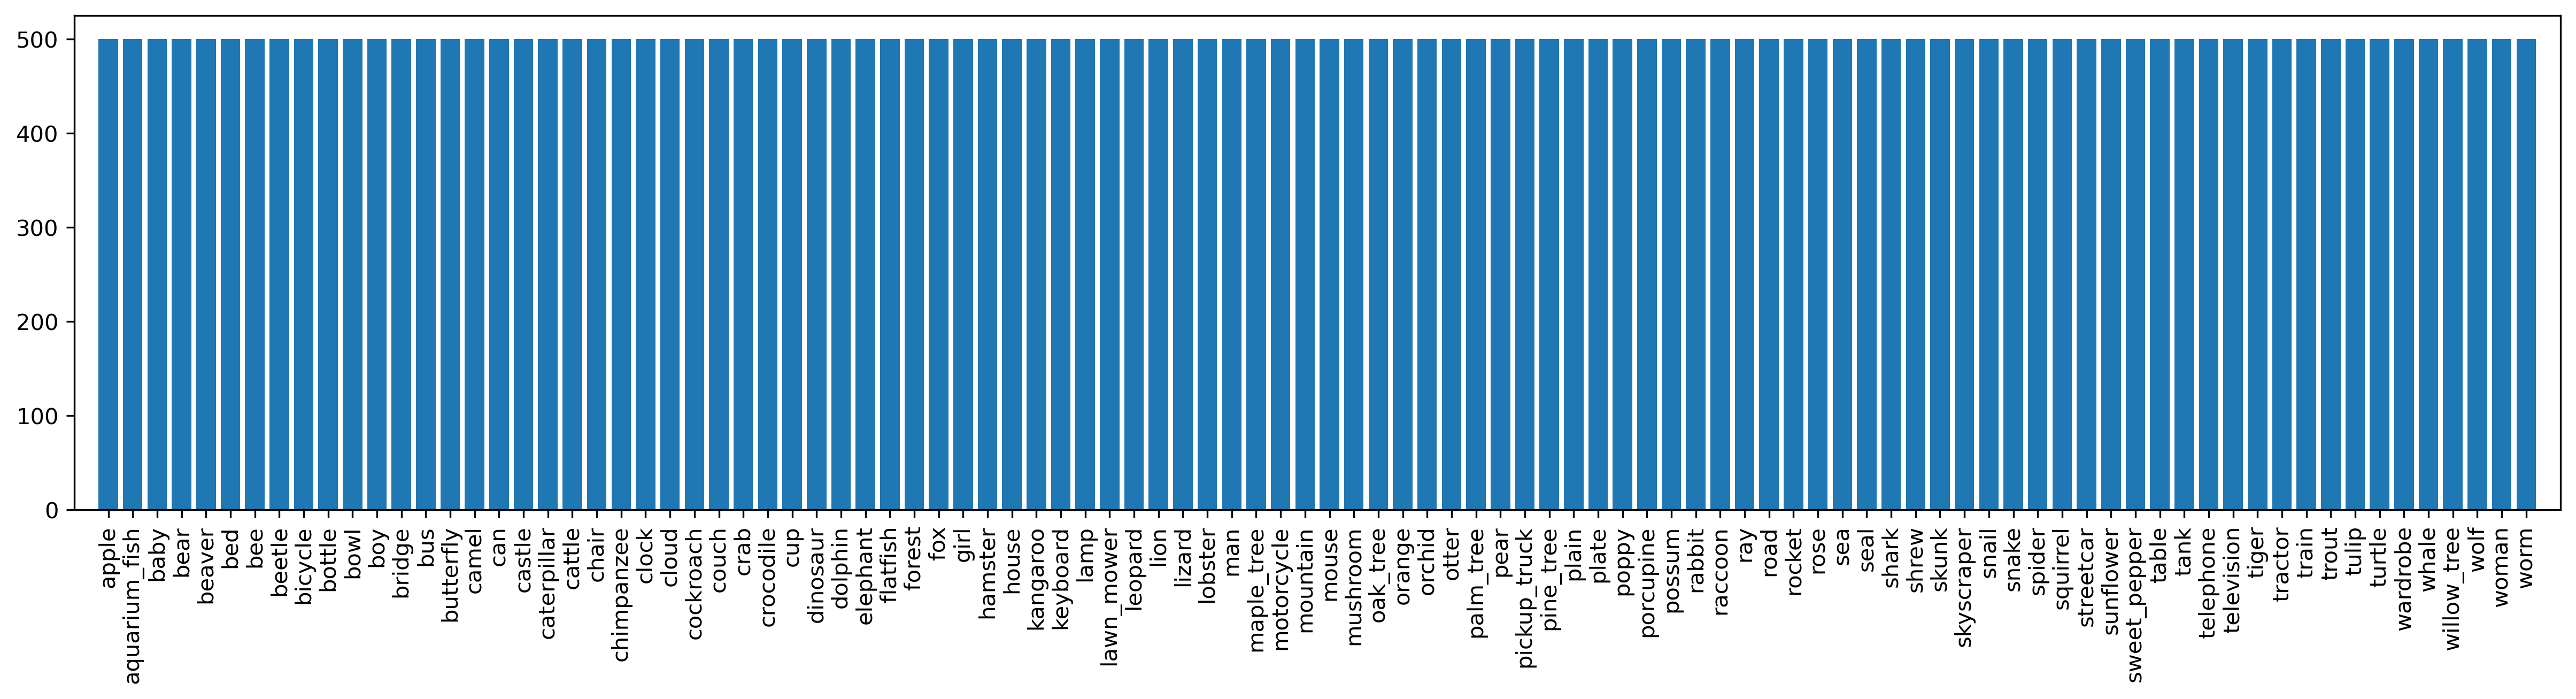

In [7]:
plt.figure(figsize=(20, 4), dpi=300)

n_samples_per_class = {
    class_: 0 for class_ in CLASSES
}

for _, labels in train_loader:
    for label in labels:
        n_samples_per_class[CLASSES[label.item()]] += 1

plt.xticks(rotation=90, ha="center")
plt.margins(x=0.01)
plt.bar(n_samples_per_class.keys(), n_samples_per_class.values())

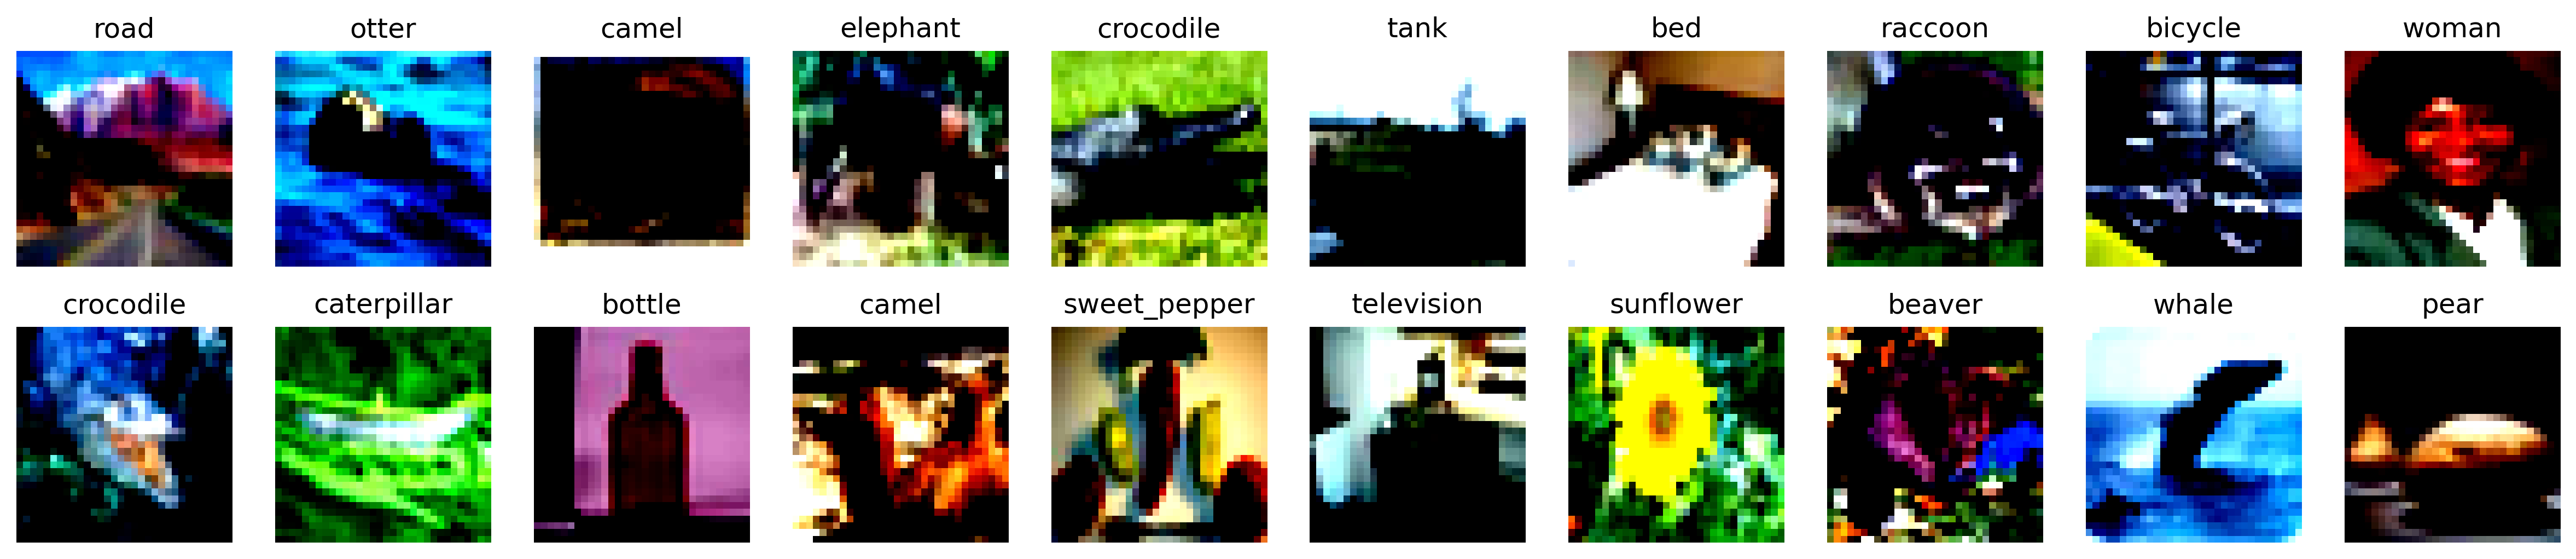

In [8]:
images, labels = next(iter(train_loader))
images = images[:20]
labels = labels[:20]

plt.figure(figsize=(20, 4), dpi=300)
plot_images(images, labels)

torch.Size([32, 32, 3])


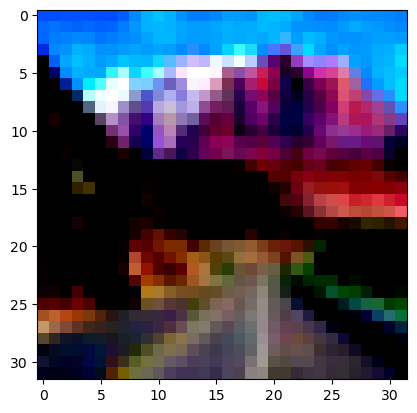

In [9]:
# plt.imshow(images[0].T)
# print (images[0].T.shape)
# plt.imshow(images[0].T)
# print (images[0].T.shape)
# plt.imshow(images[0].T)
print (images[0].reshape(32, 32, 3).shape)
plt.imshow( images[0].cpu().numpy().transpose( (1, 2, 0) ) )

In [10]:
print (f"Train dataset size: {train_ds.data.size}")

Train dataset size: 153600000


In [11]:
try:
    from pytorch_model_summary import summary
except ImportError:
    %pip install pytorch_model_summary --user

In [12]:
import numpy as np

from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

from pytorch_model_summary import summary

from tqdm import tqdm

In [13]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.linear = nn.Sequential(
            nn.Linear(in_features=384, out_features=384*4*4),
            nn.LeakyReLU(0.2),
            # Reshaping into (384, 4, 4) the input in forward method
        )

        self.upsample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2), # (384, 8, 8)
            nn.Conv2d(in_channels=384, out_channels=512, kernel_size=5, padding="same"), # (512, 8, 8)
            nn.LeakyReLU(0.2),
            nn.UpsamplingBilinear2d(scale_factor=2), # (512, 16, 16)
            nn.Conv2d(in_channels=512, out_channels=768, kernel_size=5, padding="same"), # (768, 16, 16)
            nn.LeakyReLU(0.2),
            nn.UpsamplingBilinear2d(scale_factor=2), # (768, 32, 32)
            nn.Conv2d(in_channels=768, out_channels=1024, kernel_size=5, padding="same"), # (1024, 32, 32)
            nn.LeakyReLU(0.2),
        )

        self.down_sample = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=4, padding="same"),  # (512, 32, 32)
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 3, kernel_size=4, padding="same"),  # (3, 32, 32)
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 384, 4, 4)
        x = self.upsample(x)
        x = self.down_sample(x)
        return F.tanh(x)

In [14]:
generator = Generator().to(device)
generator_optimizer = Adam(generator.parameters(), lr=gen_lr)

In [15]:
print (summary(generator.to("cpu"),pt.Tensor(384, device="cpu")))

--------------------------------------------------------------------------------
             Layer (type)          Output Shape         Param #     Tr. Param #
                 Linear-1                [6144]       2,365,440       2,365,440
              LeakyReLU-2                [6144]               0               0
   UpsamplingBilinear2d-3        [1, 384, 8, 8]               0               0
                 Conv2d-4        [1, 512, 8, 8]       4,915,712       4,915,712
              LeakyReLU-5        [1, 512, 8, 8]               0               0
   UpsamplingBilinear2d-6      [1, 512, 16, 16]               0               0
                 Conv2d-7      [1, 768, 16, 16]       9,831,168       9,831,168
              LeakyReLU-8      [1, 768, 16, 16]               0               0
   UpsamplingBilinear2d-9      [1, 768, 32, 32]               0               0
                Conv2d-10     [1, 1024, 32, 32]      19,661,824      19,661,824
             LeakyReLU-11     [1, 1024,

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:460: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:895.)
  self.padding, self.dilation, self.groups)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [16]:
class Descriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.__conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1), # ((32 - 3) + 2*0) / 1 + 1 = 30
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.MaxPool2d(2), # Max pool kernel size is 2x2, hence 30 / 2 = 15
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),  # ((15 - 3) + 2*0) / 1 + 1 = 13
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),  # ((13 - 3) + 2*0) / 1 + 1 = 11
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.MaxPool2d(2),  # Max pool kernel size is 2x2, hence 13 / 2 = 5
        )
        self.__linear_block = nn.Sequential(
            nn.Linear(in_features=128*5*5, out_features=512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=1),
        )

    def forward(self, x):
        x = self.__conv_block(x)
        x = x.view(-1, 128*5*5)
        x = self.__linear_block(x)
        return F.sigmoid(x)

In [17]:
descriminator = Descriminator().to(device)
descriminator_optimizer = Adam(descriminator.parameters(), lr=desc_lr)

In [18]:
print (summary(descriminator.to("cpu"), pt.zeros((1, 3, 32, 32), device="cpu")))

------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 32, 30, 30]             896             896
       LeakyReLU-2      [1, 32, 30, 30]               0               0
         Dropout-3      [1, 32, 30, 30]               0               0
       MaxPool2d-4      [1, 32, 15, 15]               0               0
          Conv2d-5      [1, 64, 13, 13]          18,496          18,496
       LeakyReLU-6      [1, 64, 13, 13]               0               0
         Dropout-7      [1, 64, 13, 13]               0               0
          Conv2d-8     [1, 128, 11, 11]          73,856          73,856
       LeakyReLU-9     [1, 128, 11, 11]               0               0
        Dropout-10     [1, 128, 11, 11]               0               0
      MaxPool2d-11       [1, 128, 5, 5]               0               0
         Linear-12             [1, 512]       1,638,912       1

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


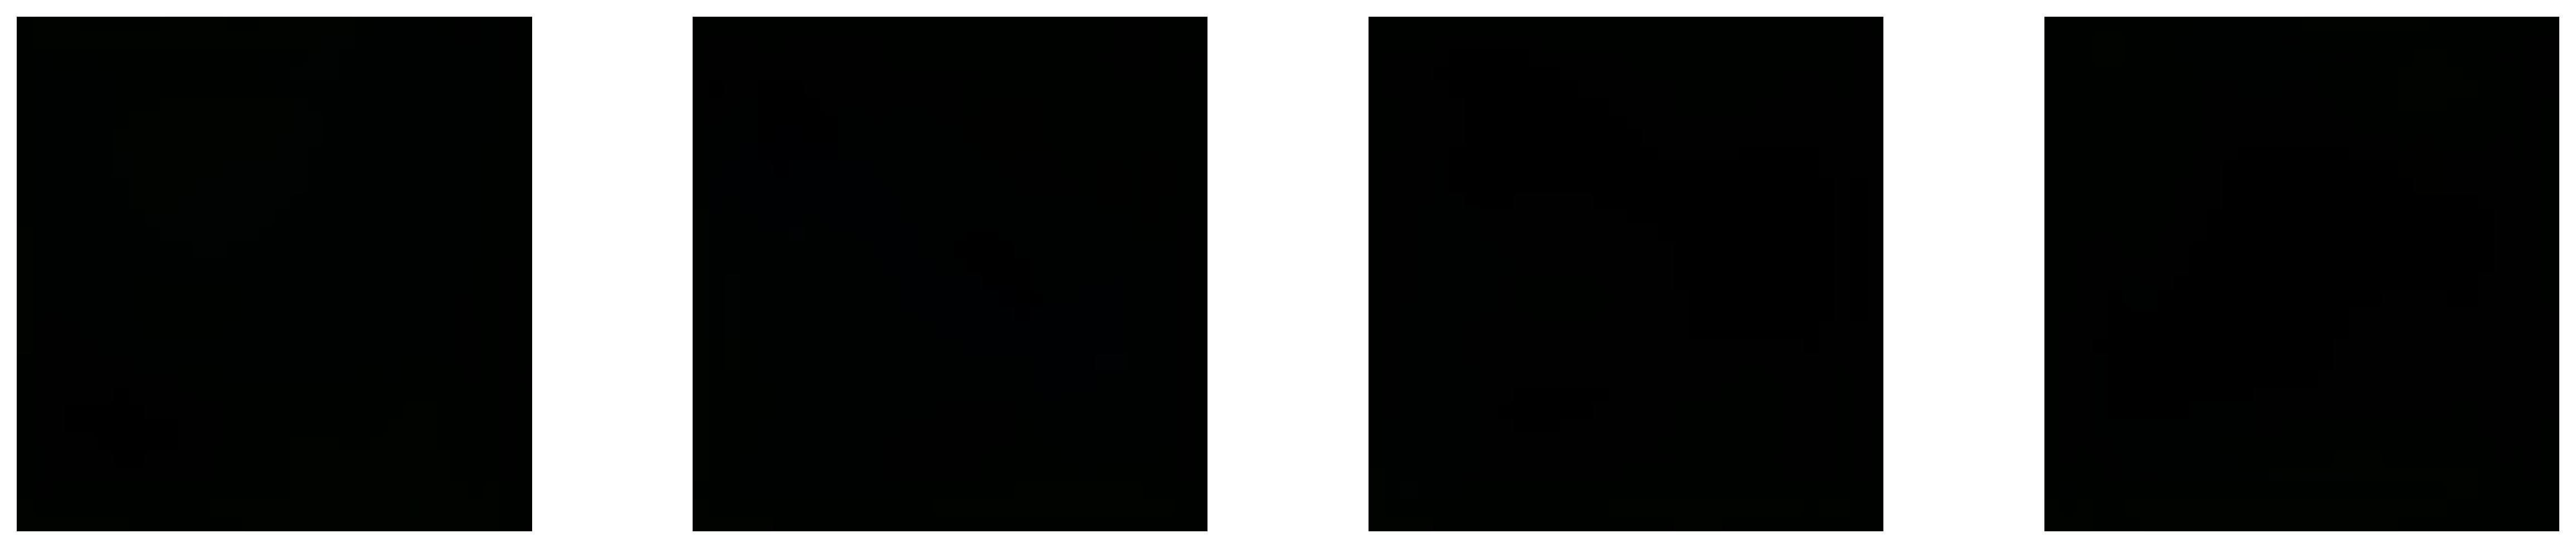

In [19]:
plt.figure(figsize=(20, 4), dpi=300)

generator = generator.to(device).eval()
garbage = pt.from_numpy(np.random.normal(size=(4, 1, 384))).to(dtype=pt.float32, device=device)

predicted = generator(garbage)
plot_images(predicted)

In [20]:
descriminator = descriminator.eval().to(device)
predicted = descriminator(images.to(device))

print (f"Dataset image size: {images.size()}")
print (f"Model Generate images: {predicted}")

Dataset image size: torch.Size([20, 3, 32, 32])
Model Generate images: tensor([[0.5099],
        [0.5037],
        [0.5013],
        [0.5043],
        [0.5043],
        [0.5095],
        [0.5097],
        [0.5031],
        [0.5111],
        [0.5117],
        [0.5084],
        [0.5080],
        [0.5072],
        [0.5093],
        [0.5106],
        [0.5105],
        [0.5109],
        [0.5128],
        [0.5082],
        [0.5101]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [21]:
adversarial_loss = pt.nn.BCELoss()

In [22]:
def train(current_epoch, total_epochs, generator, descriminator):
    d_loss_list, g_loss_list = [], []

    for images, _ in tqdm(train_loader):

        real_images = images.to(device)

        real_labels = pt.ones(size=(real_images.shape[0], 1), device=device, requires_grad=False)
        fake_labels = pt.zeros(size=(real_images.shape[0], 1), device=device, requires_grad=False)

# Generator Training
# -------------------------------------------------------------------------------------------------------------------------------------------------

        generator_optimizer.zero_grad()
        generator = generator.to(device).train()

        predicted_images = generator(
            pt.from_numpy(np.random.normal(size=(real_images.shape[0], 1, 384))).to(dtype=pt.float32, device=device),
        )

        descriminator = descriminator.to(device).eval()
        g_loss = adversarial_loss(descriminator(predicted_images), real_labels)

        g_loss.backward()

        generator_optimizer.step()
        g_loss_list.append(g_loss.item())

# Descriminator Training
# -------------------------------------------------------------------------------------------------------------------------------------------------

        descriminator_optimizer.zero_grad()

        descriminator = descriminator.to(device).train()

        noise_real = 0.15 * pt.from_numpy(np.random.uniform(size=real_labels.shape)).to(dtype=pt.float32, device=device)
        noise_fake = -0.15 * pt.from_numpy(np.random.uniform(size=fake_labels.shape)).to(dtype=pt.float32, device=device)

        real_image_desc_pred = descriminator(real_images) + noise_real
        pred_image_desc_pred = descriminator(predicted_images.detach()) + noise_fake

#         print (f"real_image_desc_pred.shape: {real_image_desc_pred.shape}")
#         print (f"pred_image_desc_pred.shape: {pred_image_desc_pred.shape}")
#         print (f"noise_real.shape: {noise_real.shape}")
#         print (f"noise_fake.shape: {noise_fake.shape}")

#         real_image_desc_pred += noise_real
#         pred_image_desc_pred += noise_fake
#         print (f"real_image_desc_pred.shape: {real_image_desc_pred.shape}")
#         print (f"pred_image_desc_pred.shape: {pred_image_desc_pred.shape}")

        d_real_loss = adversarial_loss(real_image_desc_pred, real_labels)
        d_fake_loss = adversarial_loss(pred_image_desc_pred, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()

        descriminator_optimizer.step()
        d_loss_list.append(d_loss.item())

# Miscellaneous...
# -------------------------------------------------------------------------------------------------------------------------------------------------

    print (f"Epoch: {current_epoch+1}/{total_epochs} Descriminator loss: {d_loss.item():.6f}", end="; ")
    print (f"Generator Training loss: {g_loss.item():.6f}")

# Real Time Visualization (While Training)
# -------------------------------------------------------------------------------------------------------------------------------------------------

    generator = generator.to(device).eval()
    
    nrows = 1
    ncols = 5
    sample_z_in_train = pt.from_numpy(np.random.normal(size=(nrows*ncols, 1, 384))).to(dtype=pt.float32, device=device)
    sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu().numpy()

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 2))

    for ncol, sample_gen_img_in_train in enumerate(sample_gen_imgs_in_train):
        # Using mT instead of T, as T is generally used to reverse 2 dim tensor shape, and is deprecated
        axes[ncol].imshow(sample_gen_img_in_train.transpose((1, 2, 0)))
        axes[ncol].axis('off')
    plt.show()

# Miscmiscellaneous
# -------------------------------------------------------------------------------------------------------------------------------------------------

    return {
        "generator_loss": g_loss_list,
        "descriminator_loss": d_loss_list
    }

In [23]:
total_epochs = 2000

gen_loss = []
desc_loss = []
for epoch in range(total_epochs):
    temp = train(epoch, total_epochs, generator, descriminator)

    gen_loss.append(temp["generator_loss"])
    desc_loss.append(temp["descriminator_loss"])

  4%|▍         | 32/834 [00:18<07:31,  1.78it/s]
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [47,0,0] Assertion `input_val >= zero && input_val <= one` failed.


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [ ]:
plt.subplot(1, 4, 1)
plt.plot(desc_loss, label="Descriminator Loss")
plt.legend(loc="upper right")
plt.title("Descriminator Train Loss")

plt.subplot(1, 4, 3)
plt.plot(gen_loss, label="Generator Loss")
plt.legend(loc="upper right")
plt.title("Descriminator Train Accuracy")
plt.title("Generator Train Loss")

In [ ]:
pt.save(generator, "./generator.pt")
pt.save(descriminator, "./descriminator.pt")